In [45]:
import torch
import importlib
import callback, my_attn
importlib.reload(callback)
importlib.reload(my_attn)
from diffusers import StableDiffusionPipeline, DDIMInverseScheduler, DDIMScheduler
from my_attn import prep_unet_attention
from tqdm.notebook import tqdm
from callback import QKVRecordCallback
from utils import load_image, img_to_latents, concat_img 

Same code with `callback.py`. Do not run this.

In [35]:
device = 'cuda'
dtype = torch.float16
sd15 = '/home/tom/fshare/models/runwayml/stable-diffusion-v1-5'
sd21 = '/home/tom/fshare/models/Stability-AI/stable-diffusion-2-1'

pipe = StableDiffusionPipeline.from_pretrained(
    sd15, safety_checker=None, torch_dtype=dtype)
pipe.to(device)
vae = pipe.vae
sampling_scheduler = pipe.scheduler
inverse_scheduler = DDIMInverseScheduler.from_pretrained(
    sd15, subfolder='scheduler')
ddim_scheduler = DDIMScheduler.from_pretrained(sd15, subfolder='scheduler')

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


#### Inverse process

Inverse the image and record the 12th and 13th attn_block. Use `DDIMInverseScheduler`.

The list of attn_blocks is in `callback.py`.

```Python
ATTN_BLOCKS = [
    'down_blocks.0.attentions.0.transformer_blocks.0.attn1',
    'down_blocks.0.attentions.0.transformer_blocks.0.attn2',
    'down_blocks.0.attentions.1.transformer_blocks.0.attn1',
    'down_blocks.0.attentions.1.transformer_blocks.0.attn2',
    'down_blocks.1.attentions.0.transformer_blocks.0.attn1',
    'down_blocks.1.attentions.0.transformer_blocks.0.attn2',
    'down_blocks.1.attentions.1.transformer_blocks.0.attn1',
    'down_blocks.1.attentions.1.transformer_blocks.0.attn2',
    'down_blocks.2.attentions.0.transformer_blocks.0.attn1',
    'down_blocks.2.attentions.0.transformer_blocks.0.attn2',
    'down_blocks.2.attentions.1.transformer_blocks.0.attn1',
    'down_blocks.2.attentions.1.transformer_blocks.0.attn2',
    'up_blocks.1.attentions.0.transformer_blocks.0.attn1',
    'up_blocks.1.attentions.0.transformer_blocks.0.attn2',
    'up_blocks.1.attentions.1.transformer_blocks.0.attn1',
    'up_blocks.1.attentions.1.transformer_blocks.0.attn2',
    'up_blocks.1.attentions.2.transformer_blocks.0.attn1',
    'up_blocks.1.attentions.2.transformer_blocks.0.attn2',
    'up_blocks.2.attentions.0.transformer_blocks.0.attn1',
    'up_blocks.2.attentions.0.transformer_blocks.0.attn2',
    'up_blocks.2.attentions.1.transformer_blocks.0.attn1',
    'up_blocks.2.attentions.1.transformer_blocks.0.attn2',
    'up_blocks.2.attentions.2.transformer_blocks.0.attn1',
    'up_blocks.2.attentions.2.transformer_blocks.0.attn2',
    'up_blocks.3.attentions.0.transformer_blocks.0.attn1',
    'up_blocks.3.attentions.0.transformer_blocks.0.attn2',
    'up_blocks.3.attentions.1.transformer_blocks.0.attn1',
    'up_blocks.3.attentions.1.transformer_blocks.0.attn2',
    'up_blocks.3.attentions.2.transformer_blocks.0.attn1',
    'up_blocks.3.attentions.2.transformer_blocks.0.attn2',
    'mid_block.attentions.0.transformer_blocks.0.attn1',
    'mid_block.attentions.0.transformer_blocks.0.attn2',
]
```

In [36]:
num_inversion_steps = 999
prep_unet_attention(pipe.unet)
imgname = 'images/atri_canny.jpg'
input_img = load_image(
    imgname,
    target_size=(512, 512)
).to(device=device, dtype=dtype)
prompt_inversion = "an anime girl with background"

with torch.no_grad():
    attn_record_index = []
    inverse_callback = QKVRecordCallback(
        pipe,
        attn_index=[1, 2, 12, 13],
        record_per_step=25,
        start=0,
        end=1000,
        name='inverse',
    )
    pipe.scheduler = inverse_scheduler
    latents = img_to_latents(input_img, vae)  # VAE latent
    inv_latents, _ = pipe(
        prompt=prompt_inversion,
        guidance_scale=1,
        width=input_img.shape[-1],
        height=input_img.shape[-2],
        output_type='latent',
        return_dict=False,
        num_inference_steps=num_inversion_steps,
        latents=latents,
        callback_on_step_end=inverse_callback
    )

  0%|          | 0/999 [00:00<?, ?it/s]

#### Reconstruct Process

Use `DDIMScheduler`. Different prompts and guidance scales can be tried here.

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

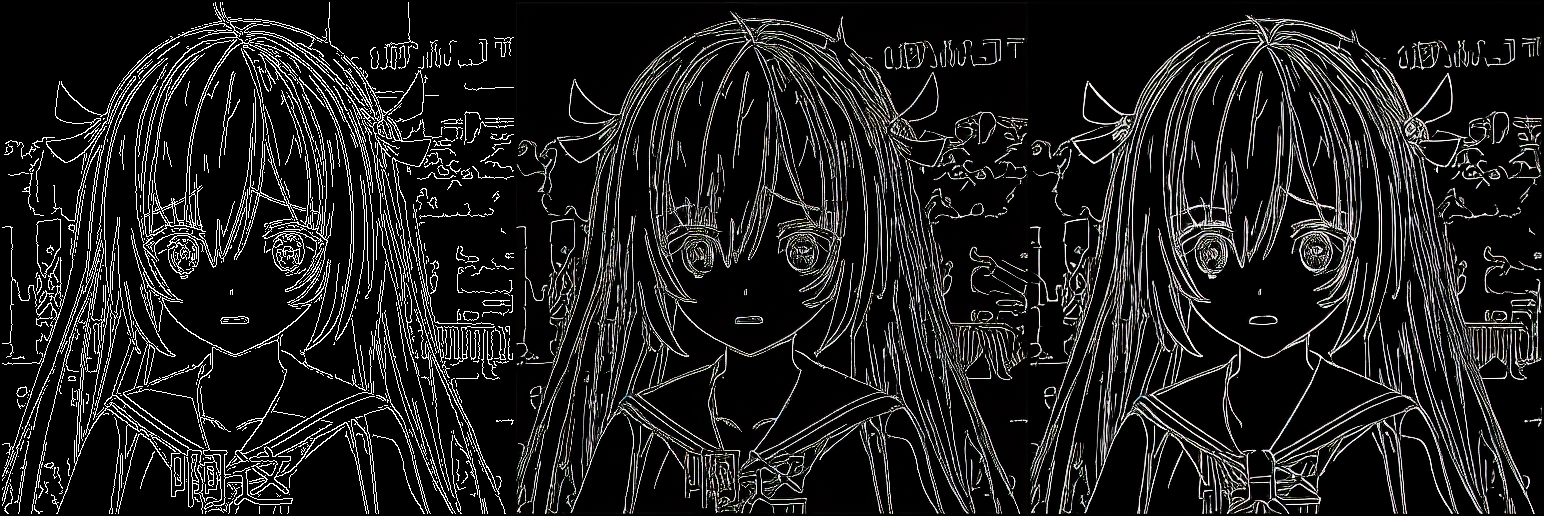

In [40]:
num_generation_steps_1 = 50
num_generation_steps_2 = 50
prompt_1 = prompt_inversion
prompt_2 = prompt_inversion + ', best quality, masterpieces'
with torch.no_grad():
    pipe.scheduler = sampling_scheduler
    image1 = pipe(
        prompt=prompt_1,
        guidance_scale=1,
        num_inference_steps=num_generation_steps_1,
        latents=inv_latents,
        output_type='pt',
    ).images[0]
    image2 = pipe(
        prompt=prompt_2,
        guidance_scale=2,
        num_inference_steps=num_generation_steps_2,
        latents=inv_latents, 
        output_type='pt',
        negative_prompt="longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality"
    ).images[0]
    original = input_img[0]
concat_img([original.unsqueeze(0), image1.unsqueeze(0), image2.unsqueeze(0)])

In [44]:
pipe.scheduler.counter

51

#### Attn Visualization for Inversion process

  0%|          | 0/40 [00:00<?, ?it/s]

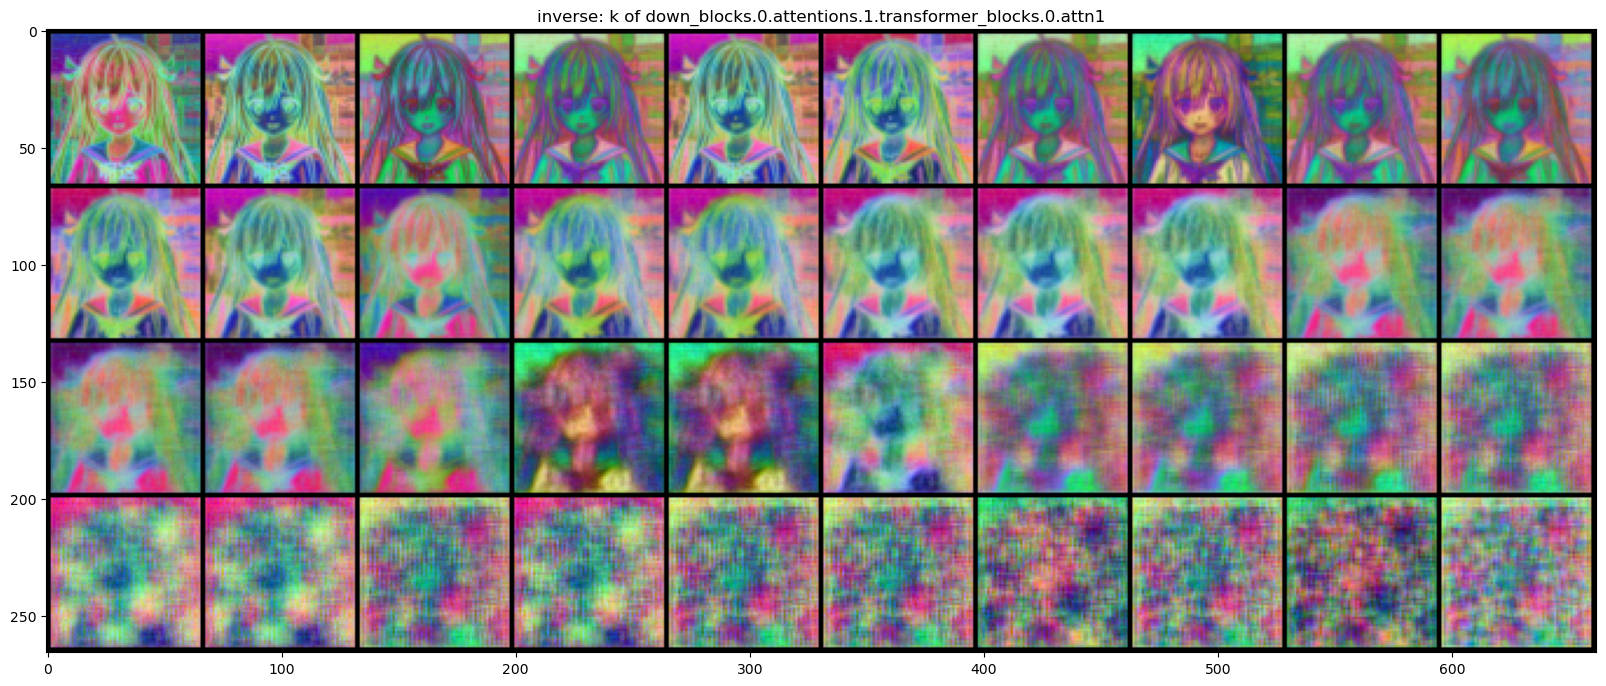

In [14]:
inverse_callback.qkv_visualization(12, 'k', 3)

  0%|          | 0/40 [00:00<?, ?it/s]

['an</w>', 'anime</w>', 'girl</w>', 'with</w>', 'background</w>']


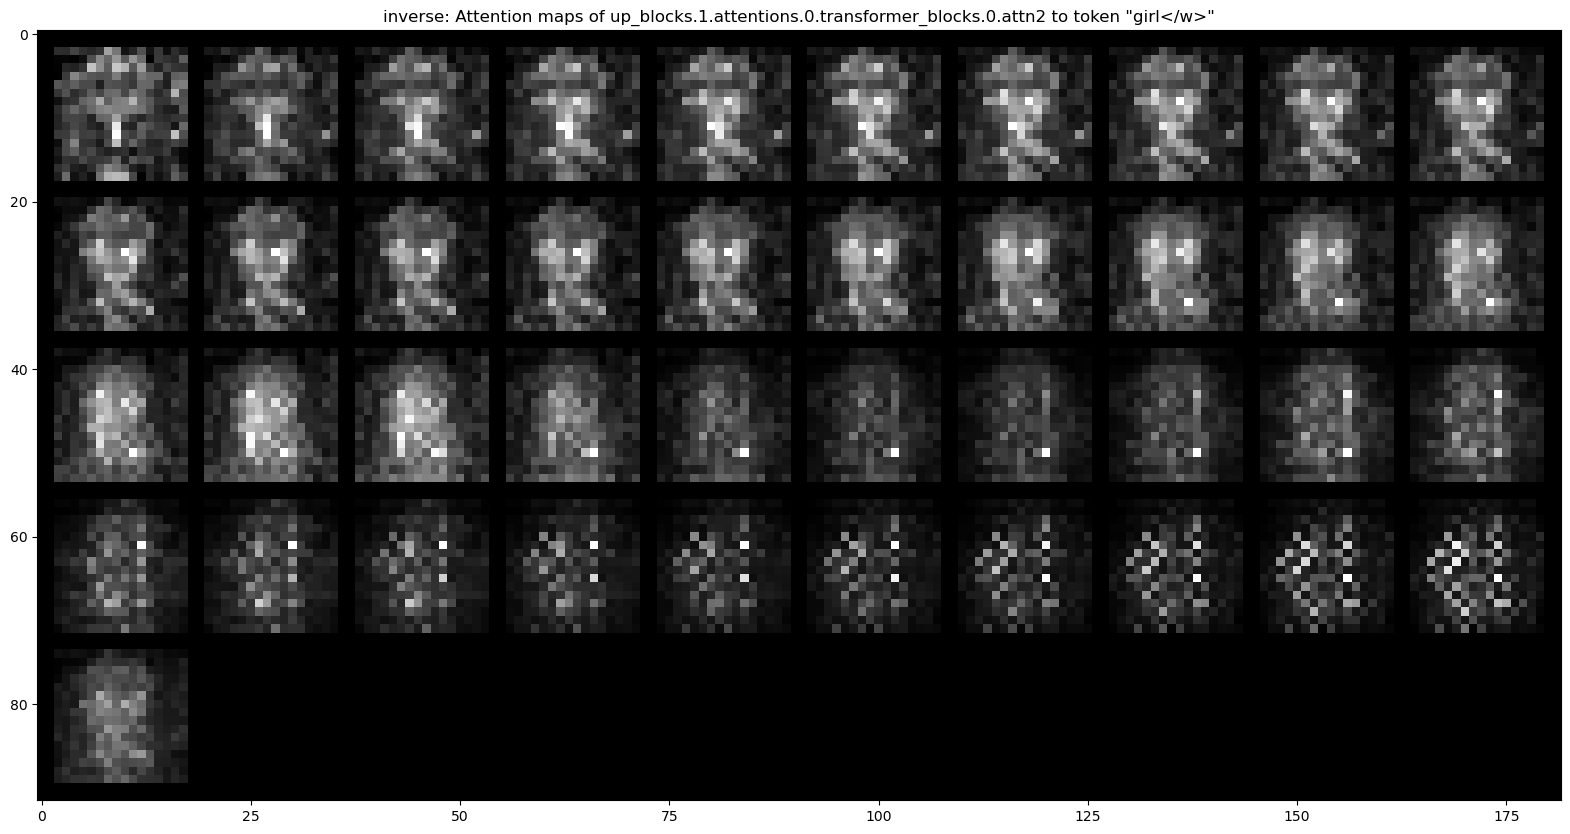

In [16]:
inverse_callback.attn_map_visualization(attn_id=13, pos=2, temperature=1, prompt=prompt_inversion, chunk=1)

In [ ]:
from callback import ATTN_BLOCKS
for _ in inverse_callback.attentions[ATTN_BLOCKS[12]]:
    print(_.t)

tensor(976, device='cuda:0')
tensor(951, device='cuda:0')
tensor(926, device='cuda:0')
tensor(901, device='cuda:0')
tensor(876, device='cuda:0')
tensor(851, device='cuda:0')
tensor(826, device='cuda:0')
tensor(801, device='cuda:0')
tensor(776, device='cuda:0')
tensor(751, device='cuda:0')
tensor(726, device='cuda:0')
tensor(701, device='cuda:0')
tensor(676, device='cuda:0')
tensor(651, device='cuda:0')
tensor(626, device='cuda:0')
tensor(601, device='cuda:0')
tensor(576, device='cuda:0')
tensor(551, device='cuda:0')
tensor(526, device='cuda:0')
tensor(501, device='cuda:0')
tensor(476, device='cuda:0')
tensor(451, device='cuda:0')
tensor(426, device='cuda:0')
tensor(401, device='cuda:0')
tensor(376, device='cuda:0')
tensor(351, device='cuda:0')
tensor(326, device='cuda:0')
tensor(301, device='cuda:0')
tensor(276, device='cuda:0')
tensor(251, device='cuda:0')
tensor(226, device='cuda:0')
tensor(201, device='cuda:0')
tensor(176, device='cuda:0')
tensor(151, device='cuda:0')
tensor(126, de

In [ ]:
def update_class_instances(instance, new_class):
    instance.__class__ = new_class

# update_class_instances(prompt1_callback, StableDiffusionCallback)
update_class_instances(inverse_callback, StableDiffusionCallback)